In [1]:
import os, zipfile, shutil
import random, numpy, torch

random.seed(0)
numpy.random.seed(0)
torch.manual_seed(0)

INPUT_DIR = './input/'
TRAIN_ZIP = INPUT_DIR+'Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised.zip'

TRAIN_DIR = INPUT_DIR+'train/'
VAL_DIR = INPUT_DIR+'val/'
VAL_TRAIN_RATIO=0.2

test_classes=['0_apse', '1_dome(outer)', '2_dome(inner)', '3_stained_glass', '4_column', 
              '5_gargoyle', '6_bell_tower', '7_vault', '8_flying_buttress', '9_altar']

train_zip=zipfile.ZipFile(TRAIN_ZIP)
train_zip.extractall(INPUT_DIR)
train_zip_dir=os.path.splitext(TRAIN_ZIP)[0]
try:
    os.replace(train_zip_dir, TRAIN_DIR)
except OSError:
    shutil.rmtree(train_zip_dir)


for test_class in test_classes:
    t_cls_split=test_class.split('_', 1)
    for train_class in os.listdir(TRAIN_DIR):    
        if train_class == t_cls_split[1]:
            os.rename(os.path.join(TRAIN_DIR, train_class), 
                      os.path.join(TRAIN_DIR, t_cls_split[0]+'_'+train_class))

test_classes=set(test_classes)
train_classes=set()
for train_class in os.listdir(TRAIN_DIR):
    train_classes.add(train_class)

extra_classes=train_classes-test_classes
print('extra train classes:', extra_classes)

for extra_class in extra_classes:
    shutil.rmtree(os.path.join(TRAIN_DIR, extra_class), ignore_errors=True)

try:
    os.makedirs(VAL_DIR)
    for img_class in os.listdir(TRAIN_DIR):
        train_class_dir=os.path.join(TRAIN_DIR, img_class)
        val_class_dir=os.path.join(VAL_DIR, img_class)
        os.makedirs(val_class_dir, exist_ok=True)
        img_list=os.listdir(train_class_dir)
        img_num=len(img_list)
        indices=random.sample(range(img_num), int(img_num*VAL_TRAIN_RATIO))
        # print(img_num, len(indices)) 
        for i in indices:
            os.replace(os.path.join(train_class_dir, img_list[i]), 
                        os.path.join(val_class_dir, img_list[i]))
except FileExistsError:
    pass


extra train classes: set()


In [2]:
from torchvision import datasets, transforms, models 
import matplotlib.pyplot as plt

BATCH_SIZE=16

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.RandomRotation((0, 180)),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    # transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255)
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, val_transforms)
print(len(train_dataset), len(val_dataset))

train_dataloader=torch.utils.data.DataLoader(train_dataset, 
    batch_size=BATCH_SIZE, drop_last=True, shuffle=True,
    num_workers=os.cpu_count())
val_dataloader=torch.utils.data.DataLoader(val_dataset, 
    batch_size=BATCH_SIZE, drop_last=True, 
    num_workers=os.cpu_count())
print(len(train_dataloader), len(val_dataloader))

8108 2022
506 126


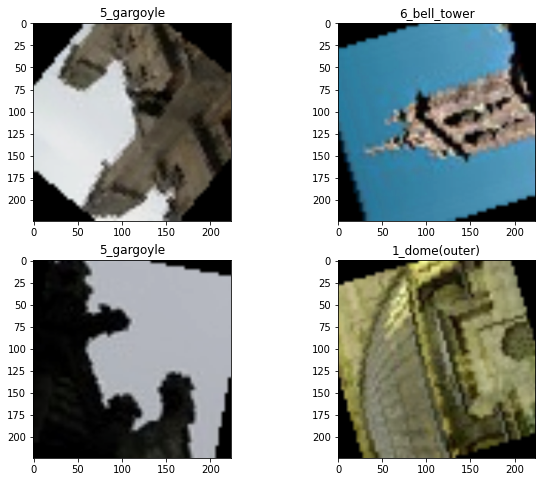

In [3]:
def show_input(input_tensor, titles=''):
    fig=plt.figure(figsize=(10, 8))
    for i in range(input_tensor.shape[0]):
        image = input_tensor[i].permute(1, 2, 0).numpy()
        image = std * image + mean
        ax=fig.add_subplot(2, 2, i+1)
        ax.imshow(image.clip(0, 1))
        ax.set_title(titles[i])
    plt.show()

X_batch, y_batch = next(iter(train_dataloader))
X_batch, y_batch = X_batch[:4, :, :, :], y_batch[:4]

show_input(X_batch, titles=[train_dataset.classes[i] for i in y_batch])

In [4]:
def train_model(model, loss_func, optimizer, train_dataloader, val_dataloader):
    epoch_tv_losses = []
    epoch_tv_accs = []
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for phase in ['train', 'val']:
        epoch_loss=0
        epoch_acc=0
        dataloader=None

        if phase=='train':
            model.train()
            dataloader=train_dataloader
        else:
            model.eval()
            dataloader=val_dataloader
        
        for X_batch, y_batch in iter(dataloader):
            X_batch=X_batch.to(device)
            y_batch=y_batch.to(device) 
            preds=model(X_batch)
            batch_loss=loss_func(preds, y_batch)
            if phase=='train':
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
            epoch_loss+=batch_loss.item()
            epoch_acc+=(y_batch == preds.argmax(dim=1)).float().mean().item()
            del X_batch
            del y_batch
            del batch_loss
        
        epoch_loss/=len(dataloader)
        epoch_acc/=len(dataloader)
        epoch_tv_losses.append(epoch_loss)
        epoch_tv_accs.append(epoch_acc)
   
    return epoch_tv_losses, epoch_tv_accs

In [5]:
# NUM_MODELS=1
NUM_EPOCHS=100
    
model = models.resnet18(pretrained=True)

fc_in=model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(fc_in, fc_in//2),
    torch.nn.PReLU(),
    torch.nn.Linear(fc_in//2, len(train_dataset.classes)))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print('model is on:', next(model.parameters()).device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=1.0e-1, weight_decay=1e-3) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-3, verbose=True)

all_tv_losses=[[], []]
all_tv_accs=[[], []]
phases=['train', 'val']
for epoch in range(NUM_EPOCHS):
    print('\n_________________')
    print('EPOCH NUM', epoch, '/', NUM_EPOCHS-1)
    print('_________________')
    tv_losses, tv_accs=train_model(model, loss_func, optimizer, train_dataloader, val_dataloader)
    for i in range(2):
        all_tv_losses[i].append(tv_losses[i])
        all_tv_accs[i].append(tv_accs[i])
        if i==0:
            scheduler.step(tv_losses[i])
        print(f'{phases[i]} loss: {tv_losses[i]:.5}, accuracy: {tv_accs[i]:.5}')

model is on: cuda:0

_________________
EPOCH NUM 0 / 99
_________________
train loss: 1.1666, accuracy: 0.61141
val loss: 0.61256, accuracy: 0.79762

_________________
EPOCH NUM 1 / 99
_________________
train loss: 0.86884, accuracy: 0.71776
val loss: 0.59507, accuracy: 0.81498

_________________
EPOCH NUM 2 / 99
_________________
train loss: 0.76923, accuracy: 0.74271
val loss: 0.94891, accuracy: 0.68651

_________________
EPOCH NUM 3 / 99
_________________
train loss: 0.70721, accuracy: 0.77359
val loss: 0.64348, accuracy: 0.77629

_________________
EPOCH NUM 4 / 99
_________________
train loss: 0.66947, accuracy: 0.78162
val loss: 0.51802, accuracy: 0.82589

_________________
EPOCH NUM 5 / 99
_________________
train loss: 0.63238, accuracy: 0.79064
val loss: 0.58745, accuracy: 0.81349

_________________
EPOCH NUM 6 / 99
_________________
train loss: 0.62334, accuracy: 0.79632
val loss: 0.7832, accuracy: 0.75744

_________________
EPOCH NUM 7 / 99
_________________
train loss: 0.5951

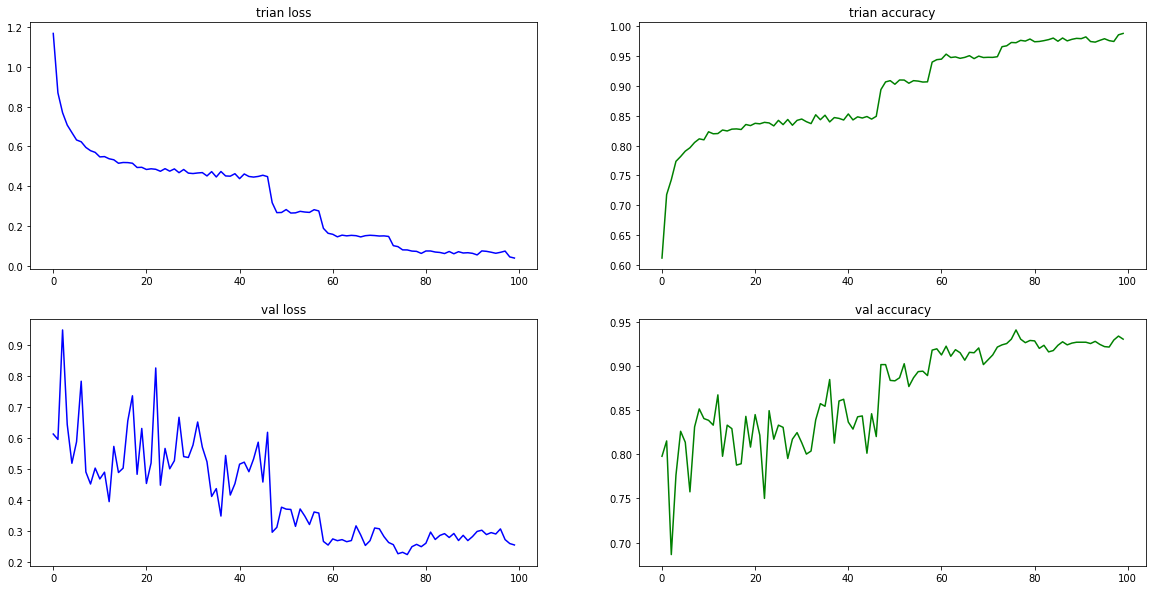

In [6]:
def show_stats(all_losses, all_accs):
    fig=plt.figure(figsize=(20, 10))
    phases=['trian', 'val']
    quilities=['loss', 'accuracy']
    count=1
    for i in range(len(phases)):
        ax=fig.add_subplot(2, 2, count)
        count+=1
        ax.plot(all_losses[i], 'b')
        ax.set_title(phases[i]+' loss')
        ax=fig.add_subplot(2, 2, count)
        count+=1
        ax.plot(all_accs[i], 'g')
        ax.set_title(phases[i]+' accuracy')
    
    plt.show()  


show_stats(all_tv_losses, all_tv_accs)

In [7]:
# torch.save(model, 'resnet18_mod.pth')